In [1]:
import sys
sys.path.append("..") # This is for the imports from adjacent folders to work

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600

import numpy as np
from main_functions.ME_solver import solve_master_equation
from main_functions.generalized_original_circuit import get_circuit
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2
import math
from qiskit import generate_preset_pass_manager
from utils.generate_complementary_colors import generate_complementary_colors
import random

In [2]:
def get_populations(n_emitters, result):
    """
    Measures the excited state population of each qubit from a PubResult
    """
    evs = {str(i) : [] for i in range(n_emitters)}
    std_devs = {str(i) : [] for i in range(n_emitters)}

    for k in range(len(result)):
        pub_result = result[k]
        shots = pub_result.data.meas.num_shots
        counts = pub_result.data.meas.get_counts()
        states = [key[math.trunc(n_emitters/2):] for key in counts.keys()] # Output states
        coeff = [ np.sqrt(counts[key]/shots) for key in counts.keys()] # Normalized coefficients
        eigenvalues = [1, -1] # Z eigenvalues

        for i in range(n_emitters):

            ev = 0.5*( 1 - sum([ (coeff[j]**2)*eigenvalues[int(states[j][-i-1])] for j in range(len(states)) ]))
            evs[str(i)].append( ev ) # Fix this
            var = ev*( 1 - ev )
            var = max(var, 0.0) #To avoid negative sqrts
            std_devs[str(i)].append(np.sqrt( var / shots )) 
    
    return evs, std_devs

In [8]:
num_emitters = 5
num_ancilla = np.floor(num_emitters/2)

omega_m = np.ones(num_emitters)*1.2
omega_c = 1.1
gamma = np.ones(num_emitters)*0.8*(10**(-6))
kappa = [0.2]
g = np.ones(2*num_emitters - 1)*0.03 
a = np.linspace(0, 1, 200)
t = 750*(np.array([x**1.5 for x in a]))
k = 8
initial_excited = ["1", "2", "4"]
shots = 10**3

backend = AerSimulator()
sampler = SamplerV2(mode = backend, options = {'default_shots' : shots})
qc = get_circuit(num_emitters, omega_m, omega_c, g, gamma, kappa, initial_excited, k)
qc.measure_all()
pm = generate_preset_pass_manager(optimization_level=2, backend = AerSimulator())
isa_qc = pm.run(qc)
pubs = [ (isa_qc.decompose(reps = 2), x) for x in t ]

job = sampler.run(pubs)
result = job.result()
evs, std_evs = get_populations(num_emitters, result)

In [ ]:
num_emitters = 5
num_ancilla = np.floor(num_emitters/2)

omega_m = np.ones(num_emitters)*1.2
omega_c = 1.1
gamma = np.ones(num_emitters)*0.8*(10**(-6))
kappa = [0.2]
g = np.ones(2*num_emitters - 1)*0.03 
a = np.linspace(0, 1, 200)
t = 750*(np.array([x**1.5 for x in a]))
k = 8
initial_excited = ["1", "2", "4"]
shots = 10**3

from qiskit_aer.primitives import SamplerV2 as Sampler
sampler = Sampler(options=dict(backend_options=dict(method="matrix_product_state")))
aer_backend = AerSimulator(method='matrix_product_state')

qc = get_circuit(num_emitters, omega_m, omega_c, g, gamma, kappa, initial_excited, k)
qc.measure_all()
pm = generate_preset_pass_manager(optimization_level=2, backend = AerSimulator())
isa_qc = pm.run(qc)
pubs = [ (isa_qc.decompose(reps = 2), x) for x in t ]

job = sampler.run(pubs)
result = job.result()
mps_evs, std_evs = get_populations(num_emitters, result)
mps_evs = np.savez("../datasets/qiskit_MPS_results.npz", evs)

In [5]:
qutip_result = solve_master_equation(num_emitters, omega_m, omega_c, gamma, kappa, g, t, initial_excited, 'markovian')

c:\Users\benti\AppData\Local\Programs\Python\Python313\Lib\site-packages\qutip\solver\solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


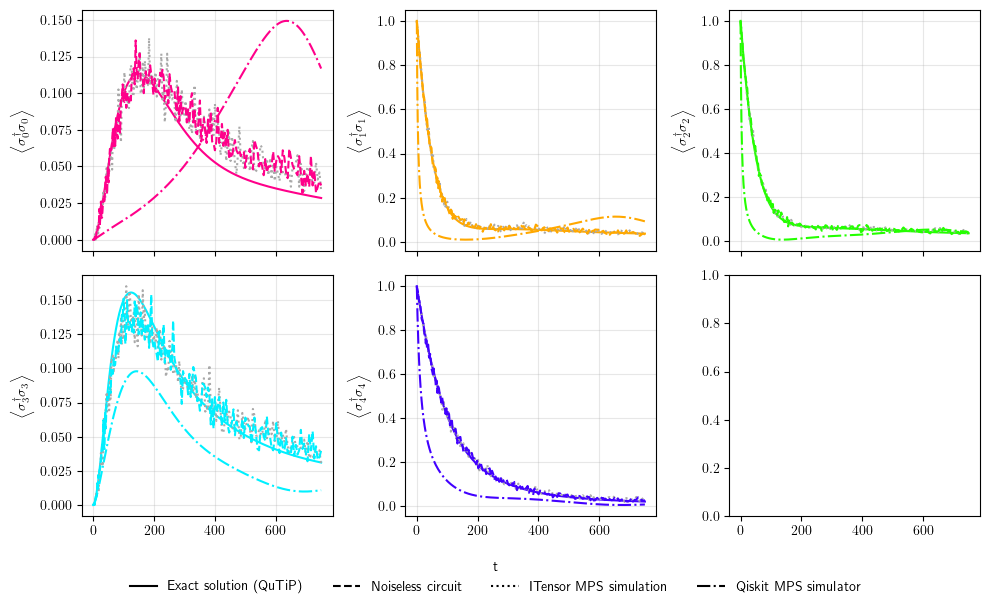

In [24]:
mps_evs = np.load("../datasets/MPS_results.npz")
qiskit_mps_evs = np.load("../datasets/qiskit_MPS_results.npz", allow_pickle=True)['arr_0'].item()

plot_qubits = evs.keys()
colors = generate_complementary_colors(len(plot_qubits), 'neon', 'deeppink')
fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharex=True)

axes = axes.flatten()  

# Plot each qubit
for i, qubit in enumerate(plot_qubits):
    ax = axes[i]
    color = colors[i]

    ax.plot(t, qutip_result[qubit], linestyle='solid', color=color)
    ax.plot(t, qiskit_mps_evs[qubit], linestyle='dotted', color='darkgrey')
    ax.plot(t, evs[qubit], linestyle='dashed', color=color)
    ax.plot(t, mps_evs[qubit], linestyle='dashdot', color=color)

    ax.set_ylabel(f'$\\left< \\sigma^{{\\dagger}}_{{{int(qubit)}}} \\sigma_{{{int(qubit)}}} \\right>$')
    ax.grid(True, alpha=0.3)

# Shared x label
fig.text(0.5, 0.04, 't', ha='center')

handles = [
    plt.Line2D([], [], linestyle='solid', color='black', label='Exact solution (QuTiP)'),
    plt.Line2D([], [], linestyle='dashed', color='black', label='Noiseless circuit'),
    plt.Line2D([], [], linestyle='dotted', color='black', label='ITensor MPS simulation'),
    plt.Line2D([], [], linestyle='dashdot', color='black', label='Qiskit MPS simulator')
]

fig.legend(handles=handles, loc='lower center', ncol=4, frameon=False, bbox_to_anchor=(0.5, -0.02))

plt.tight_layout(rect=[0, 0.07, 1, 1])
plt.savefig('../figs/MPS_comparison_5_emitters', bbox_inches='tight')
plt.show()